# Set up directories and files

In [5]:
# Configure input files

indir = "/Users/rmoraski/Documents/iCloud/School/Electrons/NISTView-ish/"
imSuffix = "_ix.sempa"
mxSuffix = "_mx.sempa"
mySuffix = "_my.sempa"
#mySuffix = "_mz.sempa"

name = "191001_Fe_whisker/Fe_whisker"
run = 1

file = indir + name + f'{run:0>3}'

In [2]:
import os
import io

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from PIL import Image

from scipy.ndimage import gaussian_filter, median_filter, rotate, zoom
from scipy.signal import convolve2d
import scipy.misc

from netCDF4 import Dataset

from colorspacious import cspace_convert

try:
    from jupyterthemes import jtplot
    jtplot.style(theme='onedork')
except ImportError:
    pass

In [3]:
# Define convenience functions


def combine_phase_and_contrast(phase, contrast):
    """Adjust the intensity of the contrast image according to phase magnitude"""

    # Set up the colormap
    cmap = create_ciecam02_cmap()

    # Use CIECAM02 color map, convert to sRGB1 (to facilitate intensity adjustment)
    im = cmap(contrast / (2 * np.pi))
    im_srgb = im[:, :, :3]
    im_adjusted = np.zeros_like(im_srgb)

    # Apply phase intensity mask to the contrast: low intensity -> dark, high intensity -> light
    for i in range(3):
        im_adjusted[:, :, i] = np.multiply(im_srgb[:, :, i], phase)

    return im_adjusted


def create_ciecam02_cmap():
    """Create a perceptually uniform colormap based on CIECAM02"""
    # Based on https://stackoverflow.com/questions/23712207/cyclic-colormap-without-visual-distortions-for-use-in-phase-angle-plots

    # first draw a circle in the cylindrical JCh color space.
    # First channel is lightness, second chroma, third hue in degrees.
    color_circle = np.ones((256, 3)) * 60
    color_circle[:, 1] = np.ones((256)) * 45
    color_circle[:, 2] = np.arange(0, 360, 360 / 256)
    color_circle_rgb = cspace_convert(color_circle, 'JCh', 'sRGB1')

    return mpl.colors.ListedColormap(color_circle_rgb)


def create_gradient(image, left=1, right=1, midpoint=0.5, angle=0):
    """Create a gradient image for removing imaging artifacts"""

    # Find darkest and lightest values in image
    dark, light = np.min(image), np.max(image)
    l, r = left * dark, right * light

    # Get the starting shape and convert the angle to radians
    xd, yd = image.shape

    angle = angle if angle >= 0 else 360 + angle
    theta = (angle * np.pi / 180) % (np.pi / 2)

    # Calculate the size of the bounding box: this is the size needed for the gradient
    xx = int(xd * np.cos(theta) + 2 * yd * np.sin(theta))
    yy = int(yd * np.cos(theta) + 2 * xd * np.sin(theta))
    sep = int(xx * midpoint)

    # ...and calculate the size of the bounding box for the above once rotated
    xxx = int(xx * np.cos(theta) + yy * np.sin(theta))
    yyy = int(yy * np.cos(theta) + xx * np.sin(theta))

    # Calculate the offsets for the box to crop out
    lr = (xxx - xd) // 2
    tb = (yyy - yd) // 2

    width = xxx - 2 * lr
    height = yyy - 2 * tb

    # Create the gradient
    left_gradient = np.linspace(l, 0, sep)
    right_gradient = np.linspace(0, r, xx - sep)
    gradient = np.tile(np.concatenate(
        [left_gradient, right_gradient]), (yy, 1))
    gradient = rotate(gradient, angle)
    gradient = gradient[lr:xxx - lr, tb:yyy - tb]

    # And handle rounding errors
    gradient = zoom(gradient, (xd / width, yd / height))

    return gradient


def get_contrast(im_x, im_y):
    """Return combined x and y contrast"""

    contrast = np.array([np.arctan2(y, x) for x, y in zip(im_x, im_y)])

    # arctan2 works over the range -pi to pi; shift everything to 0 to 2pi for color mapping
    contrast_adjusted = contrast.ravel()
    for i in range(len(contrast_adjusted)):
        value = contrast_adjusted[i]
        positive = value >= 0
        contrast_adjusted[i] = value if positive else value + 2 * np.pi

    return contrast_adjusted.reshape(contrast.shape)


def get_phase_intensities(im_x, im_y):
    """Return an image of intensities: low -> dark, high -> light"""

    # Use x and y values to determine magnitude

    phase_intensities = [np.sqrt(x**2 + y**2)
                         for x, y in zip(im_x.ravel(), im_y.ravel())]
    phase_intensities /= np.max(phase_intensities)
    return phase_intensities.reshape(im_x.shape)


def get_scale(image):
    """Determine the size of a single pixel in the input image"""
    full_scale = np.abs(
        Dataset(file + imSuffix, 'r').variables['vertical_full_scale'][...].data)
    magnification = np.abs(
        Dataset(file + imSuffix, 'r').variables['magnification'][...].data)

    adjusted_scale = full_scale / magnification
    return adjusted_scale / image.shape[1]


def imageData(file):
    """Read a file in NetCDF format and return the image data"""
    return Dataset(file, 'r').variables['image_data']


def normalize(data):
    """Scale the input from 0 to 1"""

    data_min = np.min(data)
    data_max = np.max(data)
    data_range = np.ptp(data)

    return np.array([(i - data_min) / data_range for i in data])


def show_gradients(name, image, left=1, right=1, midpoint=0.5, angle=0):
    """Plot a 3x3 grid of image removing a gradient controlled by parameters"""

    xd, yd = image.shape
    points = 16
    X = np.linspace(xd // points, xd, points, False, dtype='uint8')
    Y = np.linspace(xd // points, xd, points, False, dtype='uint8')

    x, y = np.meshgrid(X, Y)
    xs, ys = x.ravel(), y.ravel()
    zippy = zip(xs, ys)

    plt.figure(figsize=(15, 5))

    # Show the starting points
    show_subplot_raw(image, 1, 3, 1, name + ' raw')
    ax = plt.subplot(1, 3, 2)
    ax.hist([np.average(image[x - 3:x + 4, y - 3:y + 4])
             for x, y in zippy], bins=32)
    show_subplot_raw(create_gradient(image, left, right, midpoint, angle), 1, 3,
                     3, name + ' gradient at {:.1f}°'.format(angle))

    fig, axs = plt.subplots(6, 3, figsize=(15, 30))

    for i in range(3):
        # Show a bit more and a bit less than requested
        l = (-0.05 + i / 20) + left

        for j in range(3):
            r = (-0.05 + j / 20) + right

            ax = axs[2 * i, j]
            im = image + create_gradient(image, l, r, midpoint, angle)

            show_subplot_raw(im, ax=ax)
            ax.set_title(
                'Left: {:.2f}, right: {:.2f}, midpoint: {:.2f}'.format(l, r, midpoint))

            # Collect average values around a grid of points
            vals = [np.average(im[x - 2:x + 3, y - 2:y + 3])
                    for x, y in zip(xs, ys)]
            axs[2 * i + 1, j].hist(vals, bins=32)


def show_phase_colors_circle(ax=None):
    """Plot a ring of colors for a legend"""

    xs = np.arange(0, 2 * np.pi, 0.01)
    ys = np.ones_like(xs)

    if ax == None:
        plt.figure()
        ax = plt.subplot(1, 1, 1, polar=True)

    ax.scatter(xs, ys, c=xs, s=500, cmap=create_ciecam02_cmap(),
               vmin=0, vmax=2 * np.pi)
    ax.set_yticks(())
    ax.set_anchor('W')


def show_subplot(image, rows=1, cols=1, pos=1, title='', vmin=0, vmax=1, ax=None):
    """Add a subplot with values normalized to 0..1"""

    if ax == None:
        ax = plt.subplot(rows, cols, pos)

    ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray')
    ax.grid(False)
    ax.set_title(title)

    return ax


def show_subplot_raw(image, rows=1, cols=1, pos=1, title='', ax=None):
    """Add a subplot without normalized values"""

    return show_subplot(image, rows, cols, pos, title,
                        vmin=np.min(image), vmax=np.max(image), ax=ax)


def show_vector_plot(im_x, im_y, ax=None, color='white', scale=2):
    """Create a vector plot of the domains"""

    # Get dimensions
    xd, yd = im_x.shape

    X = np.linspace(xd / 32, xd, 32, dtype=np.uint8)
    Y = np.linspace(yd / 32, yd, 32, dtype=np.uint8)

    # Create a pair of (x, y) coordinates
    U, V = np.meshgrid(X, Y)
    x, y = U.ravel(), V.ravel()

    # Pull the values at those coordinates. Had to swap x and y for the plot to orient correctly.
    # No idea why.
    Xs = convolve2d(im_x, np.ones((15, 15)), mode='same')[y, x]
    Ys = convolve2d(im_y, np.ones((15, 15)), mode='same')[y, x]

    if ax == None:
        plt.figure()
        ax = plt.subplot(1, 1, 1)

    # Show the plot
    ax.quiver(x, y, Xs, Ys, angles='uv',
              scale_units='dots', color=color, scale=scale)

In [6]:
# Read in image data. Transpose undoes the rotation the NetCDF format causes.

ddt = np.transpose(imageData(file + imSuffix))
ddx = np.transpose(imageData(file + mxSuffix))
ddy = np.transpose(imageData(file + mySuffix))

# Flatten the intensity image

ddt_blurred = median_filter(ddt, 3);
ddt_flat = ddt - ddt_blurred;

scale = get_scale(ddt)

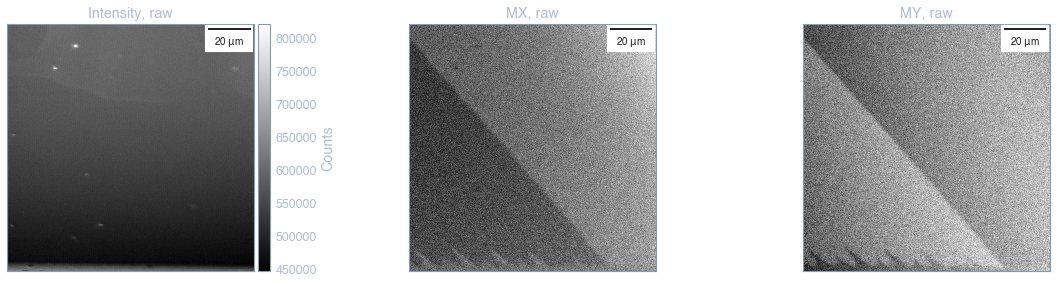

In [7]:
# Have a look at the input files

fig = plt.figure(figsize=(20, 10));

ax1 = show_subplot_raw(ddt, 2, 3, 1, 'Intensity, raw');
ax1.add_artist(ScaleBar(scale));
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)

# Add a colorbar for counts
sm = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(ddt.min(), ddt.max()))
divider = make_axes_locatable(ax1);
cax = divider.append_axes('right', size='5%', pad=0.05);
sm.set_array([]);
cbar = plt.colorbar(sm, cax=cax, orientation='vertical');
cbar.set_label('Counts')

ax2 = show_subplot_raw(ddx, 2, 3, 2, 'MX, raw');
ax2.add_artist(ScaleBar(scale));
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

ax3 = show_subplot_raw(ddy, 2, 3, 3, 'MY, raw');
ax3.add_artist(ScaleBar(scale));
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)

# Find gradient values

MX - min:       0.80, max:       1.67, PtP:       0.87


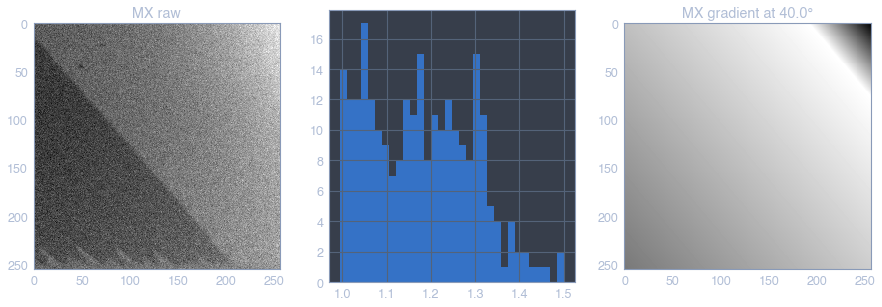

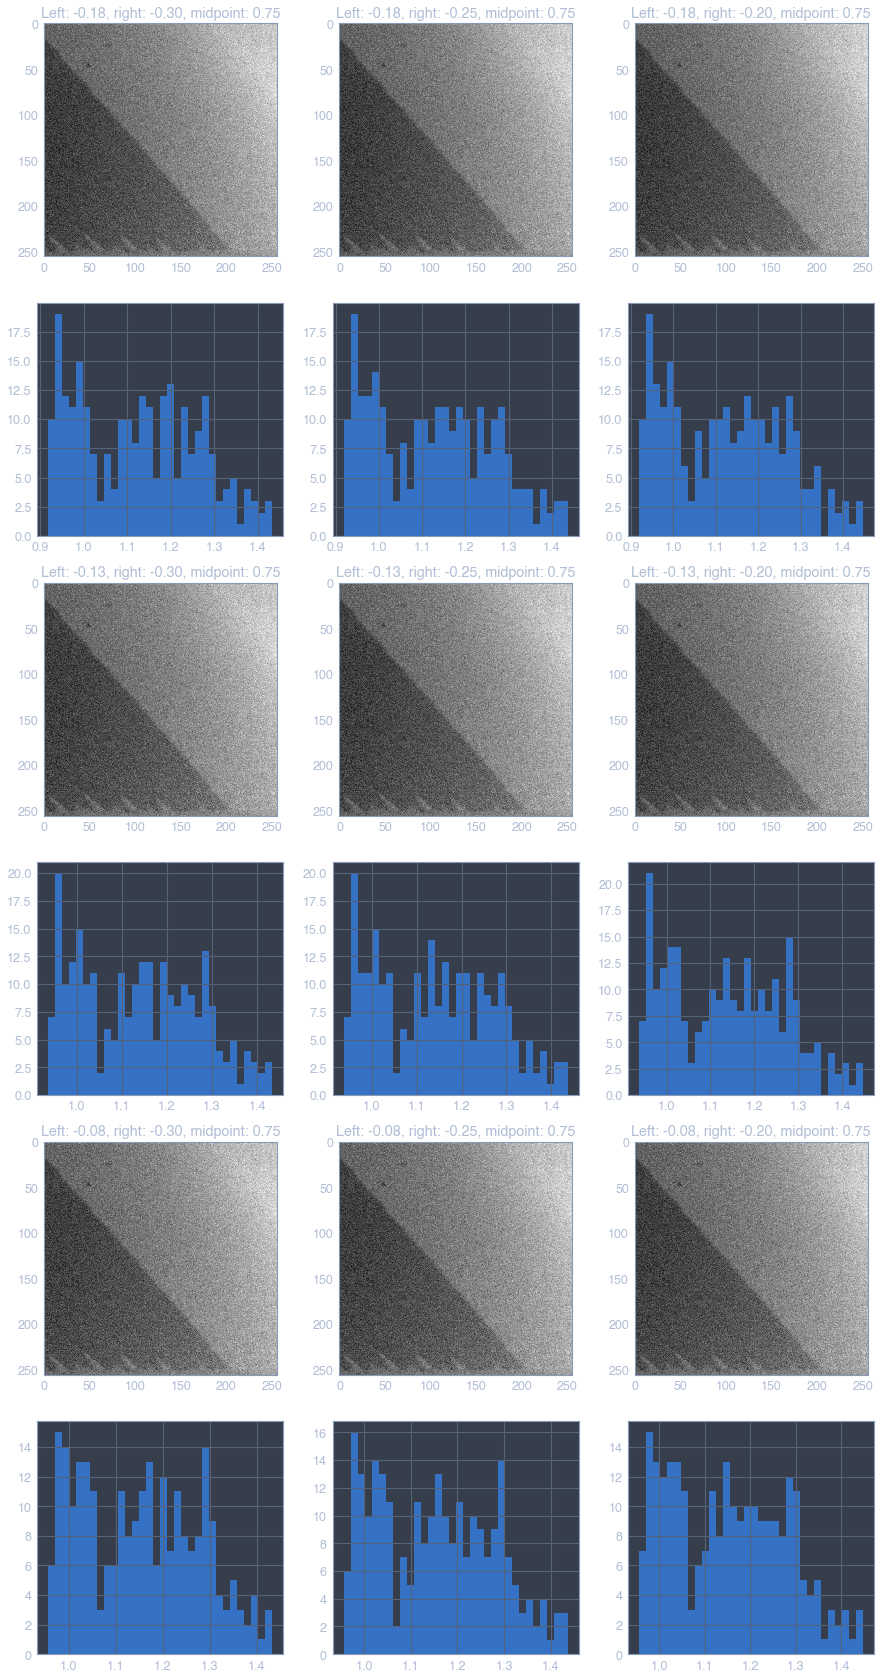

In [8]:
# Find a suitable gradient strength for x

left, right, midpoint, angle = -0.13, -0.25, 0.75, 40 # run 1
#left, right, midpoint, angle = 0.13, -0.1, 0.7, 12 # run 2

show_gradients('MX', ddx, left, right, midpoint, angle)

print('MX - min: {:10.2f}, max: {:10.2f}, PtP: {:10.2f}'.format(
    ddx.min(), ddx.max(), np.ptp(ddx)))

MY - min:      -0.48, max:       0.26, PtP:       0.74


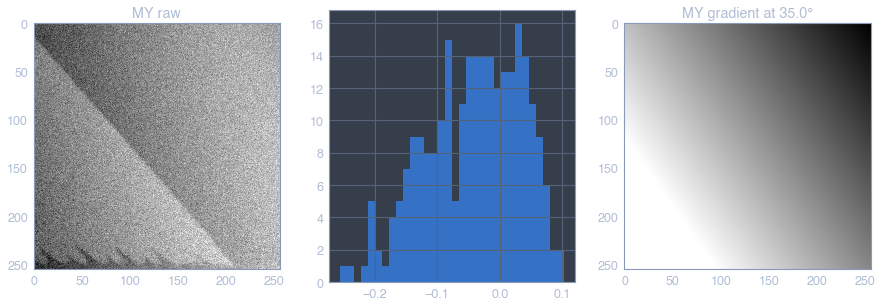

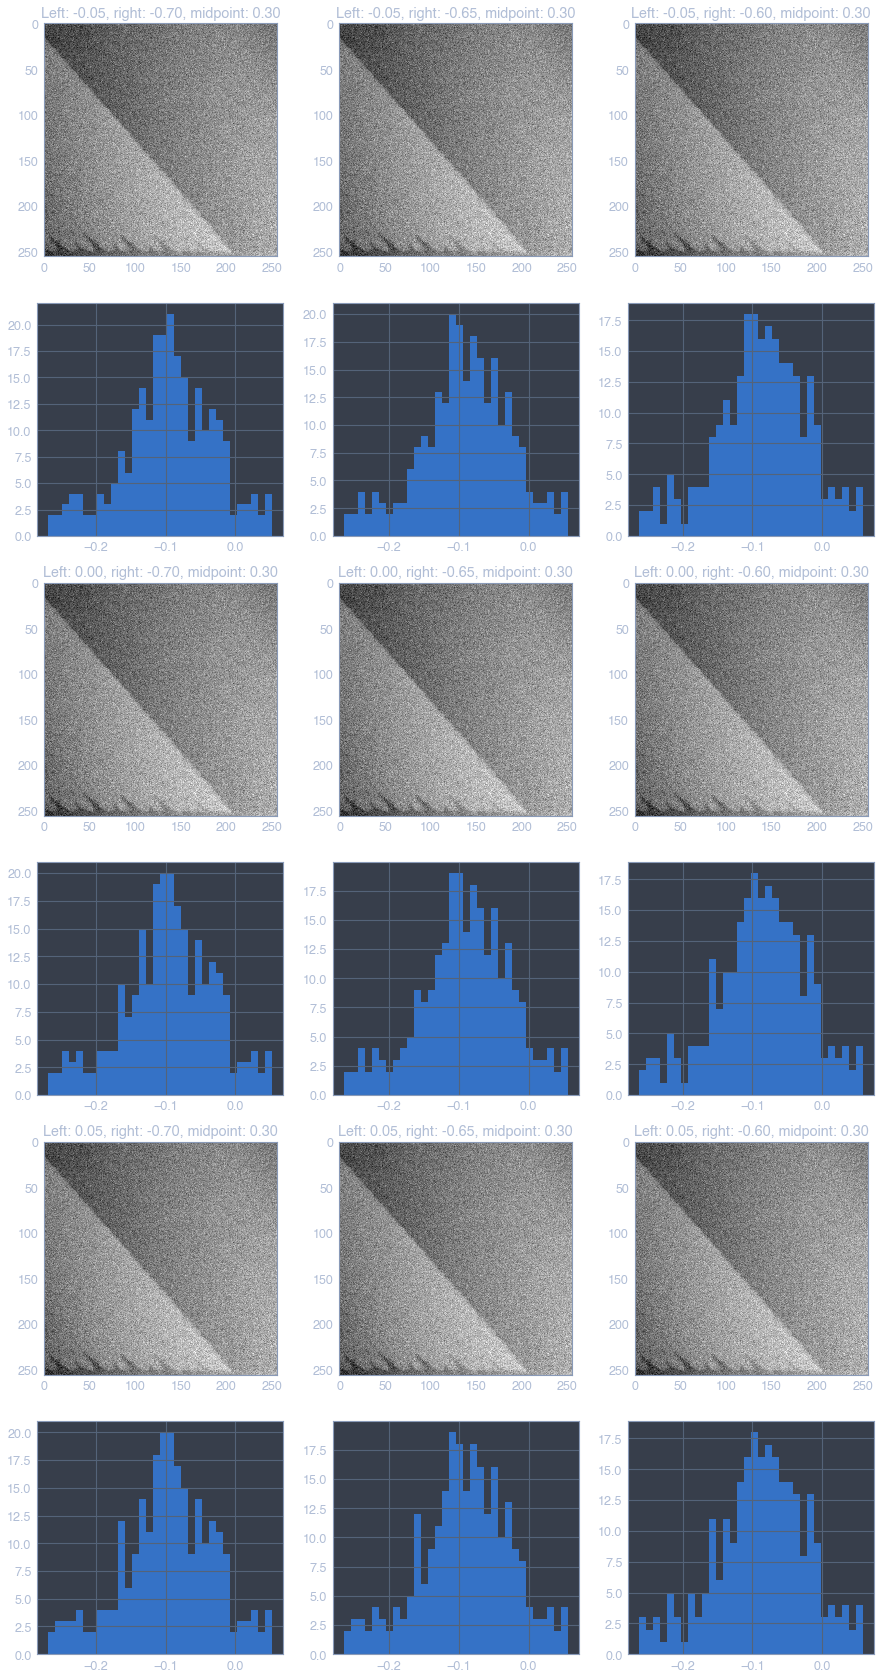

In [9]:
# Find a suitable gradient strength for y

left, right, midpoint, angle = 0, -0.65, 0.3, 35 # run 1
#left, right, midpoint, angle = -0.35, -0.5, 0.4, 35 # run 2

show_gradients('MY', ddy, left, right, midpoint, angle)

print('MY - min: {:10.2f}, max: {:10.2f}, PtP: {:10.2f}'.format(
    ddy.min(), ddy.max(), np.ptp(ddy)))

In [10]:
# Create filters for the contrast images based on best values from above

# run 1
ddx_gradient = create_gradient(ddx, -0.13, -0.25, 0.55, 40)
ddy_gradient = create_gradient(ddy, 0, -0.65, 0.3, 35)

# run 2
#ddx_gradient = create_gradient(ddx, 0.13, -0.1, 0.7, 12)
#ddy_gradient = create_gradient(ddy, -0.35, -0.5, 0.4, 35)

ddx_flat = ddx + ddx_gradient;
ddy_flat = ddy + ddy_gradient;

# Find offsets

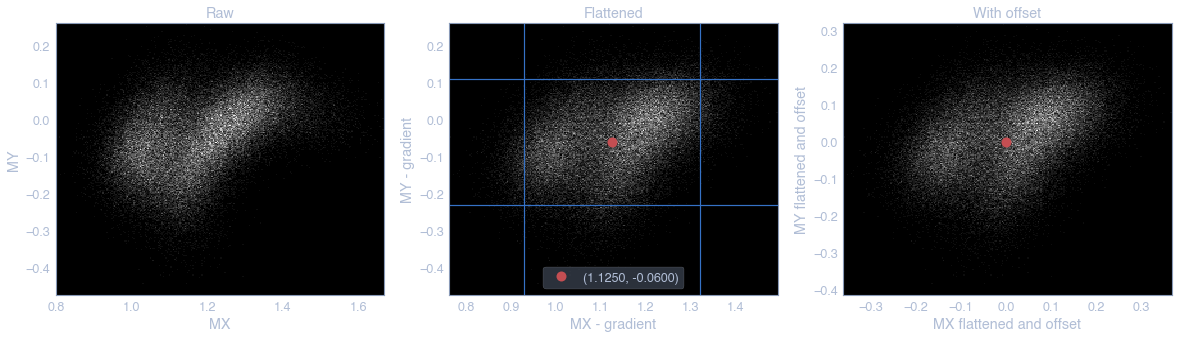

In [11]:
# Determine offset

l, r, t, b = 0.93, 1.32, 0.11, -0.23; # run 1
#l, r, t, b = 0.95, 1.4, 0.3, -0.4; # run 2

guess_x, guess_y = (l + r) / 2, (t + b) / 2;

fig = plt.figure(figsize=(20, 5));
ax1 = fig.add_subplot(1, 3, 1);
ax2 = fig.add_subplot(1, 3, 2);
ax3 = fig.add_subplot(1, 3, 3);

ax1.hist2d(ddx.ravel(), ddy.ravel(), bins=256, cmap='gray');
ax1.set_xlabel('MX');
ax1.set_ylabel('MY');
ax1.set_title('Raw');

ax2.hist2d(ddx_flat.ravel(), ddy.ravel(), bins=256, cmap='gray');
ax2.plot(guess_x, guess_y, 'ro', ms=10, label='({:.4f}, {:.4f})'.format(guess_x, guess_y));
ax2.axvline(l);
ax2.axvline(r);
ax2.axhline(t);
ax2.axhline(b);
ax2.legend();
ax2.set_xlabel('MX - gradient');
ax2.set_ylabel('MY - gradient');
ax2.set_title('Flattened');

ax3.hist2d(ddx_flat.ravel() - guess_x, ddy.ravel() - guess_y, bins=256, cmap='gray');
ax3.plot(0, 0, 'ro', ms=10);
ax3.set_xlabel('MX flattened and offset');
ax3.set_ylabel('MY flattened and offset');
ax3.set_title('With offset');

In [12]:
# Apply offset

ddx_flat = ddx_flat - guess_x
ddy_flat = ddy_flat - guess_y

print('MX flat - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    ddx_flat.min(), ddx_flat.max(), np.average(ddx_flat), np.ptp(ddx_flat)))
print('MY flat - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    ddy_flat.min(), ddy_flat.max(), np.average(ddy_flat), np.ptp(ddy_flat)))

MX flat - min: -0.36, max: 0.37, average: 0.01, PtP: 0.73
MY flat - min: -0.42, max: 0.29, average: -0.04, PtP: 0.70


In [13]:
# Use a gaussian filter to denoise

ddx_denoised = gaussian_filter(ddx_flat, 3);
ddy_denoised = gaussian_filter(ddy_flat, 3);

# Extract contrast and phase information

contrast = get_contrast(ddx_denoised, ddy_denoised)
phase_intensities = get_phase_intensities(ddx_denoised, ddy_denoised)

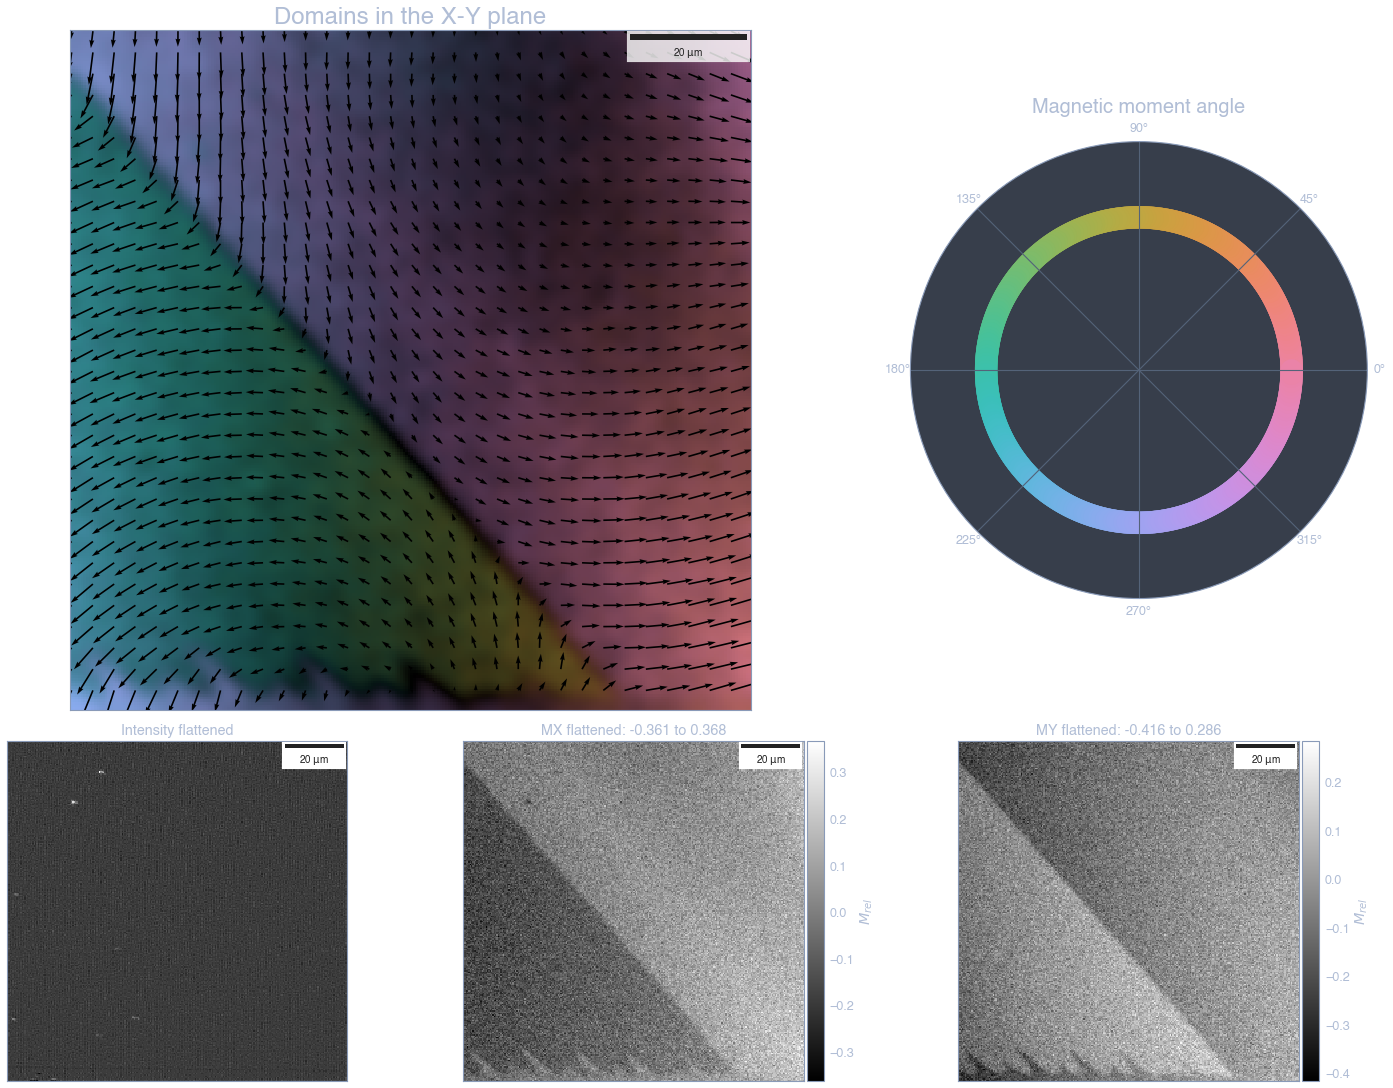

In [14]:
# Show a colorized version of the domains

im = combine_phase_and_contrast(phase_intensities, contrast)

fig = plt.figure(figsize=(20, 15), constrained_layout=True);

gs = fig.add_gridspec(3, 3)
gs.update(wspace = 0.3, hspace = 0.3)

# Contrast image
ax1 = plt.subplot(gs[:-1, :-1]);
ax1.imshow(im);
show_vector_plot(ddx_denoised, ddy_denoised, ax=ax1, color='black', scale=1.5)
ax1.add_artist(ScaleBar(scale, box_alpha=0.8));
ax1.set_title('Domains in the X-Y plane', fontdict={'fontsize': 24})

# Vector legend
ax2 = plt.subplot(gs[:-1, -1], polar=True);
show_phase_colors_circle(ax2);
ax2.set_title('Magnetic moment angle', fontdict={'fontsize': 20})

# Flattened intensity
ax3 = plt.subplot(gs[-1, 0]);
ax3.imshow(ddt_flat, cmap='gray');
ax3.add_artist(ScaleBar(scale));
ax3.set_title('Intensity flattened');

# Flattened MX
ax4 = plt.subplot(gs[-1, 1]);
ax4.imshow(ddx_flat, cmap='gray');
ax4.add_artist(ScaleBar(scale));
ax4.set_title('MX flattened: {:.3f} to {:.3f}'.format(ddx_flat.min(), ddx_flat.max()));

# Add a colorbar
sm = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(ddx_flat.min(), ddx_flat.max()))
divider = make_axes_locatable(ax4);
cax = divider.append_axes('right', size='5%', pad=0.05);
sm.set_array([]);
cbar = plt.colorbar(sm, cax=cax, orientation='vertical');
cbar.set_label(r'$M_{rel}$')

# Flattened MY
ax5 = plt.subplot(gs[-1, -1]);
ax5.imshow(ddy_flat, cmap='gray');
ax5.add_artist(ScaleBar(scale));
ax5.set_title('MY flattened: {:.3f} to {:.3f}'.format(ddy_flat.min(), ddy_flat.max()));

# Add a colorbar
sm = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(ddy_flat.min(), ddy_flat.max()))
divider = make_axes_locatable(ax5);
cax = divider.append_axes('right', size='5%', pad=0.05);
sm.set_array([]);
cbar = plt.colorbar(sm, cax=cax, orientation='vertical');
cbar.set_label(r'$M_{rel}$')

# Turn off grids and axes except for the legend plot
for ax in fig.get_axes():
    if len(ax.images) > 0:
        ax.grid(False);
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)